In [2]:
import geopandas as gpd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import fiona
from shapely.geometry import Point
from matplotlib.ticker import FuncFormatter, FixedLocator, MultipleLocator

## Import files (and convert to appropriate CRS if applicable)

In [3]:
waste = gpd.read_file("Infrastructure_Layers/wastewater_treatment_plants.gpkg")
LGAS = gpd.read_file("NVP_Locations/VIC_SA_LGAS_NVP.gpkg")
powerlines = gpd.read_file("Infrastructure_Layers/Aus_powerlines.gpkg")
translines = gpd.read_file("Infrastructure_Layers/Aus_Transmission_Lines.gpkg")
major_power = gpd.read_file("Infrastructure_Layers/Aus_MajorPower_Stations.gpkg")
substations = gpd.read_file("Infrastructure_Layers/Aus_Transmission_Substations.gpkg")
shapefile = gpd.read_file("Aus_Shapefile/STE_2021_AUST_GDA2020.shp")
colac_lin = gpd.read_file("NVP_Locations/colac_lineament.gpkg")
centres = gpd.read_file("NVP_Locations/NVP_Centres.gpkg")
watersupply = gpd.read_file("Infrastructure_Layers/Aus_Water_Reserves.gpkg")
exchange = gpd.read_file("Infrastructure_Layers/Aus_Telephone_Exchanges.gpkg")
AusAirports = gpd.read_file("Infrastructure_Layers/Aus_Airports.gpkg")
AusRunways = gpd.read_file("Infrastructure_Layers/Aus_Runways.gpkg")
Roads = gpd.read_file("Infrastructure_Layers/Aus_MajorRoads.gpkg")
Rails = gpd.read_file("Infrastructure_Layers/Aus_Railways.gpkg")
Bridges = gpd.read_file("Infrastructure_Layers/Aus_Railway_Bridges.gpkg")
exchange = gpd.read_file("Infrastructure_Layers/Aus_Telephone_Exchanges.gpkg")
radio = pd.read_csv("Infrastructure_Layers/RadioDec.csv")

C:\Users\User\miniconda3\envs\my-env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: This version of GeoPackage user_version=0x000028A0 (10400, v1.4.0) on 'NVP_Locations/NVP_Centres.gpkg' may only be partially supported
  return ogr_read(


In [4]:
geometry = [Point(xy) for xy in zip(radio["lon_dec"], radio["lat_dec"])]
gdfradio = gpd.GeoDataFrame(radio, geometry=geometry, crs="EPSG:4283")

In [5]:
shapefile=shapefile.to_crs(LGAS.crs)
powerlines=powerlines.to_crs(LGAS.crs)
translines=translines.to_crs(LGAS.crs)
major_power=major_power.to_crs(LGAS.crs)
substations = substations.to_crs(LGAS.crs)
Bridges = Bridges.to_crs(LGAS.crs)
watersupply = watersupply.to_crs(LGAS.crs)
centres = centres.to_crs(LGAS.crs)
colac_lin = colac_lin.to_crs(LGAS.crs)
AusAirports = AusAirports.to_crs(LGAS.crs)
AusRunways = AusRunways.to_crs(LGAS.crs)
exchange = exchange.to_crs(LGAS.crs)
Roads = Roads.to_crs(LGAS.crs)
Rails = Rails.to_crs(LGAS.crs)

## Create handles for legends

In [6]:
centre_proxy = Line2D([], [], marker='^', linestyle='None', color='orange',
                    markerfacecolor='orange', markeredgecolor='gray', markersize=8, label='Eruptive Centres')

### Power

In [7]:
major_proxy = Line2D([], [], marker='*', linestyle='None', color='#00be3f',
                    markerfacecolor='#00be3f', markersize=8, label='Major Power Stations')
sub_proxy = Line2D([], [], marker='*', linestyle='None', color='#a1ff5d',
                    markerfacecolor='#a1ff5d', markersize=8, label='Power Substations')
powerlines_proxy =  Line2D([], [], linestyle='-', color='purple', alpha=0.6, linewidth=4, label='Powerlines')
translines_proxy =  Line2D([], [], linestyle='-', color='pink', alpha=1, linewidth=4, label='Transmission Lines')

powerhandles = [major_proxy, sub_proxy, centre_proxy, powerlines_proxy, translines_proxy]

### Water

In [8]:
waste_proxy = Line2D([], [], marker='D', linestyle='None', color='blue',
                       markerfacecolor='blue', markersize=8, label='Wastewater Treatment Plants')

ws_proxy = Patch(facecolor='#75aefd', edgecolor='#003c8f', label='Water Supply Reserves')

waterhandles = [waste_proxy, ws_proxy, centre_proxy]

### Airports

In [9]:
airport_proxy = Line2D([], [], marker='d', linestyle='None', color='blue',
                       markerfacecolor='blue', markersize=8, label='Airports')
runway_proxy =  Line2D([], [], linestyle='-', color='red', linewidth=4, label='Runways')
airhandles = [airport_proxy, runway_proxy, centre_proxy]

### Roads and Rails

In [10]:
rails_proxy =  Line2D([], [], linestyle='-', color='red', linewidth=4, label='Railways')
roads_proxy =  Line2D([], [], linestyle='-', color='blue', linewidth=4, label='Major Highway')
bridges_proxy = Line2D([], [], marker='X', linestyle='None', color='#1a9641',
                    markerfacecolor='#1a9641', markersize=8, label='Railway Bridges')
groundhandles = [rails_proxy, roads_proxy, bridges_proxy, centre_proxy]

## Define Plot functions

### Victoria Labels

In [11]:
def Victoria_Labels(ax, title=None, xlim=(140, 145.5), ylim=(-39, -36.5), aspect=4/3):

    ax.scatter(144.97806, -37.8240, color='black', zorder=5, s=50) 
    
    

    melbourne = ax.annotate(
        'Melbourne',  
        xy=(144.97806, -36.7240),
        xytext=(144.98, -37.75),
        fontsize=8,
        color='black',
        ha="center",
        zorder=7
    )
    melbourne.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])
    
    mt_gambier = ax.annotate(
        "Mt Gambier",
        xy=(140.7659, -37.8414),
        xytext=(140.7, -37.65),
        fontsize=8,
        color="black",
        zorder=7
    )
    mt_gambier.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])

    sa = ax.annotate(
        "South Australia",
        xy=(140.6, -37.0648),
        xytext=(140.76, -37.48),
        rotation=270,
        fontsize=8,
        color='grey',
        zorder=7
    )
    sa.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])

    vic = ax.annotate(
        "Victoria",
        xy=(140.2, -37.0648),
        xytext=(141.04, -37.2),
        rotation=90,
        fontsize=8,
        color='grey',
        zorder=7
    )
    vic.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])

    colac = ax.annotate(
        "Colac Lineament",
        xy=(140.7659, -37.8414),
        xytext=(141.52, -38.73),
        fontsize=9,
        rotation=7.5,
        color="black",
        zorder=4
    )
    colac.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])


    ax.set_facecolor('#e0f4ff')
    if title:
        ax.set_title(title, fontsize=16)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(aspect, adjustable='box')
    
    

### Power

In [12]:
def plot_power(ax):
    colac_lin.plot(ax=ax, color='black', zorder=5)
    LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
    shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
    major_power.plot(ax=ax, color = '#00be3f', alpha=1, marker='*', zorder=4, markersize=90, label='Major Power Stations')
    substations.plot(ax=ax, color = '#a1ff5d', alpha=1, marker='*', zorder=3, markersize=50, label='Power Substations')
    centres.plot(ax=ax, color='orange', edgecolor='gray', markersize=15, marker='^', zorder=6, alpha=0.5, label = "Eruptive Centres")
    powerlines.plot(ax=ax, color='purple', alpha=0.6, zorder=3, label='Powerlines')
    translines.plot(ax=ax, color='pink',alpha=1, zorder=2, label='Transmission Lines')
    ax.scatter(140.78377, -37.82668, color='black', zorder=5, s=50)


    ax.set_facecolor('#e0f4ff')
    ax.set_title("Power", fontsize=16)
    leg =  ax.legend(handles=powerhandles, fontsize=9, frameon=True,loc='center',bbox_to_anchor=(0.5,-0.25), bbox_transform=ax.transAxes, ncol=3)

    xticks = np.arange(141, 146)       
    yticks = np.arange(-39, -36.4, 0.5)        
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)


    def lon_formatter(x, pos):
        return f"{int(x)}°E"

    def lat_formatter(y, pos):
        deg = abs(y)
        if deg.is_integer():
            return f"{int(deg)}°S"
        else:
            return f"{deg:.1f}°S"

    ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
    ax.yaxis.set_major_locator(MultipleLocator(1.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))

    ax.tick_params(axis='y', which='minor', length=4, color='gray')
    ax.tick_params(axis='x', which='minor', length=4, color='gray')

    ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
    ax.set_xlim(140, 145.5)
    ax.set_ylim(-39,-36.5)
    ax.set_aspect(4/3, adjustable='box')

### Water

In [13]:
def plot_water(ax):
    colac_lin.plot(ax=ax, color='black', zorder=4)
    LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
    waste.plot(ax=ax, color='#003c8f', alpha = 0.6, marker='D', zorder=4)
    shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
    watersupply.plot(ax=ax, color='#75aefd', edgecolor = '#003c8f', zorder=3)
    centres.plot(ax=ax, color='orange', edgecolor='gray', markersize=15, marker='^', zorder=2, alpha=0.6)
    ax.scatter(140.78377, -37.82668, color='black', zorder=1, s=50)
    
    xticks = np.arange(141, 146)       
    yticks = np.arange(-39, -36.4, 0.5)        
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)


    def lon_formatter(x, pos):
        return f"{int(x)}°E"

    def lat_formatter(y, pos):
        deg = abs(y)
        if deg.is_integer():
            return f"{int(deg)}°S"
        else:
            return f"{deg:.1f}°S"

    ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
    ax.yaxis.set_major_locator(MultipleLocator(1.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))

    ax.tick_params(axis='y', which='minor', length=4, color='gray')
    ax.tick_params(axis='x', which='minor', length=4, color='gray')

    ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
    ax.legend(handles=waterhandles, frameon=True,loc='center',bbox_to_anchor=(0.5,-0.25), bbox_transform=ax.transAxes, ncol=2)
    ax.set_title("Water", fontsize=16)
    ax.set_facecolor('#e0f4ff')
    ax.set_xlim(140, 145.5)
    ax.set_ylim(-39,-36.5)
    ax.set_aspect(4/3, adjustable='box')

### Airports

In [14]:
def plot_airport(ax):
    colac_lin.plot(ax=ax, color='black', zorder=2)
    LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
    AusAirports.plot(ax=ax, marker="d", markersize = 70, zorder=4, label="Airports")
    AusRunways.plot(ax=ax, color='red', linewidth=4, zorder=5, label="Runways")
    shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
    centres.plot(ax=ax, color='orange', edgecolor='gray', marker='^', markersize=15, zorder=2, alpha=0.6)
    ax.scatter(140.78377, -37.82668, color='black', zorder=5, s=50)
    ax.scatter(140.7659, -37.8414, color='orange', edgecolor='gray', marker='^', s=15, zorder=7, alpha=0.6)
    
    xticks = np.arange(141, 146)       
    yticks = np.arange(-39, -36.4, 0.5)        
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)


    def lon_formatter(x, pos):
        return f"{int(x)}°E"

    def lat_formatter(y, pos):
        deg = abs(y)
        if deg.is_integer():
            return f"{int(deg)}°S"
        else:
            return f"{deg:.1f}°S"

    ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
    ax.yaxis.set_major_locator(MultipleLocator(1.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))

    ax.tick_params(axis='y', which='minor', length=4, color='gray')
    ax.tick_params(axis='x', which='minor', length=4, color='gray')

    ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
    ax.legend(handles=airhandles, frameon=True,loc='center',bbox_to_anchor=(0.5,-0.3), ncol=2)
        
    ax.set_title("Airports", fontsize=16)
    ax.set_facecolor('#e0f4ff')
    ax.set_xlim(140, 145.5)
    ax.set_ylim(-39,-36.5)
    ax.set_aspect(4/3, adjustable='box')

### Roads and Rails

In [15]:
def plot_ground(ax):
    colac_lin.plot(ax=ax, color='black', zorder=2)
    LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
    Roads.plot(ax=ax, color='blue', linewidth=2, zorder=5, label="Major Highways")
    Rails.plot(ax=ax, color='red', linewidth=2, zorder=4, label="Rails")
    Bridges.plot(ax=ax, color='#1a9641', marker='x', zorder=6)
    shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
    centres.plot(ax=ax, color='orange', edgecolor='gray', marker='^', markersize=15, zorder=2, alpha=0.6)
    ax.scatter(140.78377, -37.82668, color='black', zorder=6, s=50)
    ax.scatter(140.7659, -37.8414, color='orange', edgecolor='gray', marker='^', s=15, zorder=7, alpha=0.6)
    
    xticks = np.arange(141, 146)       
    yticks = np.arange(-39, -36.4, 0.5)        
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)


    def lon_formatter(x, pos):
        return f"{int(x)}°E"

    def lat_formatter(y, pos):
        deg = abs(y)
        if deg.is_integer():
            return f"{int(deg)}°S"
        else:
            return f"{deg:.1f}°S"

    ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
    ax.yaxis.set_major_locator(MultipleLocator(1.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))

    ax.tick_params(axis='y', which='minor', length=4, color='gray')
    ax.tick_params(axis='x', which='minor', length=4, color='gray')

    ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
    ax.legend(handles=groundhandles, frameon=True,loc='center',bbox_to_anchor=(0.5,-0.3), ncol=2)
    ax.set_title("Roads and Railways", fontsize=16)
    ax.set_facecolor('#e0f4ff')
    ax.set_xlim(140, 145.5)
    ax.set_ylim(-39,-36.5)
    ax.set_aspect(4/3, adjustable='box')

## Create Subplot

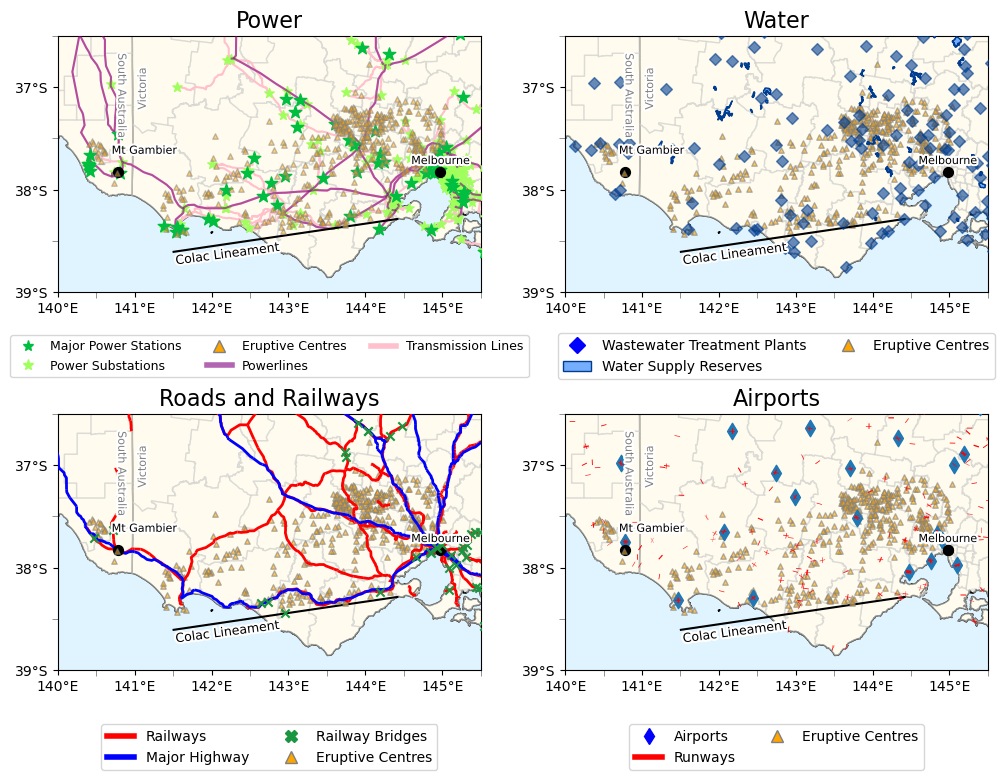

In [16]:
fig, axs = plt.subplots(2,2, figsize=[12,9])


plot_power(axs[0,0])
plot_water(axs[0,1])
plot_ground(axs[1,0])
plot_airport(axs[1,1])


for ax in axs.flatten():
    Victoria_Labels(ax) 


Victoria_Labels(ax)

plt.savefig(
    "DataMap_Outputs/Infrastructure_Multimap.png",
    dpi=600,
    bbox_inches='tight')
